In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb

import wandb
from wandb.lightgbm import wandb_callback

pd.set_option("display.max_columns", 181)
pd.set_option("display.min_rows", 200)

In [22]:
#!pip install xgboost

In [2]:
data_dictionary = pd.read_csv("DataDictionaryWiDS2021.csv")
unlabeled = pd.read_csv("UnlabeledWiDS2021.csv")
training = pd.read_csv("TrainingWiDS2021.csv")

In [3]:
column_datatype_mapping = dict(zip(data_dictionary['Variable Name'], data_dictionary['Data Type']))

In [4]:
del training['Unnamed: 0']
del unlabeled['Unnamed: 0']

In [5]:
all_data = training.drop(['encounter_id', 
                          'hospital_id', 
                          'diabetes_mellitus'], axis=1).append(unlabeled)

In [6]:
cat_cols = []
cont_cols = []
for col in all_data.columns:
    if all_data.dtypes[col] == "object":
        cat_cols.append(col)
        all_data[col] = all_data[col].fillna("NA")
        all_data[col] = LabelEncoder().fit_transform(all_data[col])
        all_data[col]= all_data[col].astype('category')
    elif column_datatype_mapping[col] == "binary":
        all_data[col] = all_data[col].fillna(-1)
    elif column_datatype_mapping[col] == "numeric":
        all_data[col] = all_data[col].fillna(0)
        cont_cols.append(col)
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())
        cont_cols.append(col)

In [90]:
df_train = all_data[:len(training)]
df_pred = all_data[len(training):].reset_index(drop=True)
Y = training['diabetes_mellitus']

In [91]:
X_train, X_val, y_train, y_val = train_test_split(df_train, Y, test_size=0.20, random_state=42,shuffle=True )

In [96]:
xg_train = xgb.DMatrix(X_train.values, label=y_train)
xg_test = xgb.DMatrix(X_val.values, label=y_val)

In [102]:
wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config


param = {'subsample': 1.0, 
         'num_leaves': 20, 
         'min_child_weight': 5, 
         'max_depth': 5, 
         'learning_rate': 0.1, 
         'gamma': 1.5, 
         'colsample_bytree': 1.0,
         'n_estimators':200,
          'eval_metric':'auc',
          'objective': 'binary:logistic'}

# wandb.config.update(params)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 500
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[wandb.xgboost.wandb_callback()])

# get prediction
pred = bst.predict(xg_test)

train-auc,0.90055
test-auc,0.8647
_step,199
_runtime,69
_timestamp,1610883449


train-auc,▁▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
test-auc,▁▂▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/opt/conda/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[11:41:50] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimators, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.80939	test-auc:0.80126
[1]	train-auc:0.81496	test-auc:0.80497
[2]	train-auc:0.82038	test-auc:0.81089
[3]	train-auc:0.82165	test-auc:0.81130
[4]	train-auc:0.82408	test-auc:0.81419
[5]	train-auc:0.82548	test-auc:0.81621
[6]	train-auc:0.82847	test-auc:0.81955
[7]	train-auc:0.82919	test-auc:0.82006
[8]	train-auc:0.83007	test-auc:0.82085
[9]	train-auc:0.83148	test-auc:0.82239
[10]	train-auc:0.83224	test-auc:0.82310
[11]	train-auc:0.83354	test-auc:0.82426
[12]	train-auc:0.83423	test-auc:0.82492
[13]	train-auc:0.83476	test-auc:0.82540
[14]	train-auc:0.83565	test-auc:0.82608
[15]	train-auc:0.83645	test-auc:0.82638
[16]	train-auc:0.83729	tes

In [103]:
#bst.fit(df_train.values, Y.values)

metrics.roc_auc_score(Y.values, bst.predict(xgb.DMatrix(df_train.values)))

0.9197601704632955

In [ ]:
#Basic model final auc: 0.7917882139874278
#0.8263166791535951
#0.8928322559066909


In [104]:
pred_proba = bst.predict(xgb.DMatrix(df_pred.values))

#pred_proba = xgbm.predict_proba(df_pred.values)[:,1]]

In [105]:
submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.fillna(0.5).to_csv('SolutionWiDS2021_XGB_500_epochs_best_params.csv')

### CV with random hpopt

In [69]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1.5, 3],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 4, 5],
        'num_leaves': [20, 30, 40],
        'learning_rate': [0.001, 0.01, 0.1]
        }


In [70]:
xgb = XGBClassifier(n_estimators=200, objective='binary:logistic', verbose=1)

In [74]:
folds = 5
param_comb = 40

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=4, cv=skf.split(df_train.values, Y), verbose=3, 
                                   random_state=1001)


In [75]:
# Here we go
import time
start=time.time()
random_search.fit(df_train.values, Y)
print(time.time()-start)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:40:04] WARNING: ../src/learner.cc:541: 
Parameters: { num_leaves, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[06:40:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
17051.079075574875


In [106]:
random_search

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f54ab3953d0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None, verbose=1,
                                          

In [89]:
print(random_search.best_params_)

{'subsample': 1.0, 'num_leaves': 20, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 1.0}


In [82]:
pred_proba_rs = random_search.predict_proba(df_pred.values)

In [ ]:
# (pred_proba, pred_proba_rs[:,1])

(array([4739., 1721.,  939.,  663.,  615.,  484.,  429.,  407.,  202.,
          35.]),
 array([0.00112045, 0.09701023, 0.19290002, 0.2887898 , 0.3846796 ,
        0.48056936, 0.57645917, 0.6723489 , 0.7682387 , 0.8641285 ,
        0.9600183 ], dtype=float32),
 <BarContainer object of 10 artists>)

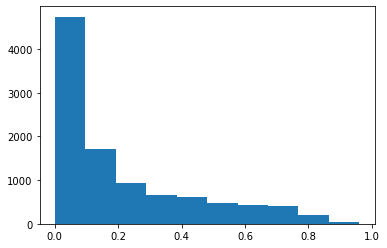

In [83]:
import matplotlib.pyplot as plt
plt.hist(pred_proba_rs[:,1])

In [84]:
submittion = pd.DataFrame([unlabeled.encounter_id,pred_proba_rs[:,1]]).T
submittion.encounter_id = submittion.encounter_id.astype('int32')
submittion.set_index('encounter_id',inplace=True)
submittion.columns = ['diabetes_mellitus']
submittion.fillna(0.5).to_csv('SolutionWiDS2021_XGB_200_epochs_CV_RandomSearch_200runs.csv')